# M54 data 

Let's try to get rid of the very young star contibution.

## Look at the data

In [1]:
cd ../

/Users/pjethwa/Astro/Science/uq4pk


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src

m54_data = uq4pk_src.data.M54()
print(m54_data.y.shape)

m54_data.logarithmically_resample(dv=50.)
print(m54_data.y.shape)

(3361,)

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

(3800,)


/var/folders/s5/ts6_t97x4lbb7lz292_yv_dw0007l9/T/ipykernel_74822/631431647.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(orient_image(np.log10(img)))


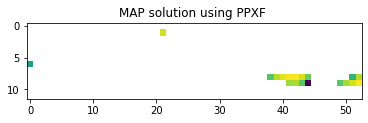

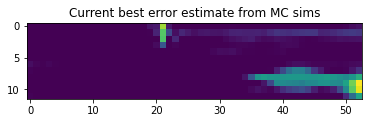

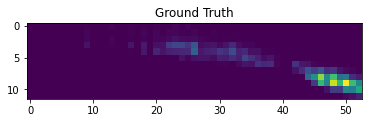

In [3]:
def orient_image(img):
    return np.flipud(img.T)

# MAP solutuon
img = m54_data.ppxf_map_solution
plt.imshow(orient_image(np.log10(img)))
plt.gca().set_title('MAP solution using PPXF ')
plt.show()

# current best error estimate
# 100 MAP solutions from monte carlo resampling of noise
img = np.std(m54_data.mcsims_map_weights, -1)
plt.imshow(orient_image(img))
plt.gca().set_title('Current best error estimate from MC sims')
plt.show()

# ground truth 
img = m54_data.ground_truth
plt.imshow(orient_image(img))
plt.gca().set_title('Ground Truth')
plt.show()

## SSP models

*Note*: the SSP models we need to fit this data are different to those we have been using previously (due to different wavelength ranges). To get the right models, follow the instructions above to get the data-files, which should then be read in as follows,

In [4]:
ssps = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=None,
    lmd_max=None,
    )
ssps.resample_spectra(m54_data.lmd)
# normalise the SSP templates to be light-weighted rather than mass-weighted,
ssps.Xw /= np.sum(ssps.Xw, 0)
ssps.dv = m54_data.dv
ssps.speed_of_light = m54_data.speed_of_light

### Re-creating the ppxf fit

In [5]:
from ppxf import ppxf

npix_buffer_mask = 20
m54_data.mask[:npix_buffer_mask] = False
m54_data.mask[-npix_buffer_mask:] = False

templates = ssps.Xw
galaxy = m54_data.y
noise = m54_data.noise_level
velscale = ssps.dv
start = [0., 30., 0., 0.]
bounds = [[-500,500], [3,300.], [-0.3,0.3], [-0.3,0.3]]
moments = 4
mask = m54_data.mask

# final pixel is NAN, breaks PPXF even though this is masked, so remove it here manually
templates = templates[:-1,:]
galaxy = galaxy[:-1]
noise = noise[:-1]
mask = mask[:-1]

ppxf_fit = ppxf.ppxf(
    templates,
    galaxy,
    noise,
    velscale,
    start=start,
    degree=-1,
    mdegree=21,
    moments=moments,
    bounds=bounds,
    regul=1e-10,
    mask=mask
)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.088     0.187
chi2/DOF: 0.9353; degree = -1; mdegree = 21
method = capfit; Jac calls: 9; Func calls: 241; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  22 / 636


/var/folders/s5/ts6_t97x4lbb7lz292_yv_dw0007l9/T/ipykernel_74822/739162578.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.flipud(np.log10(f_ppxf)))


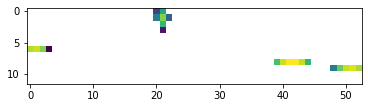

In [6]:
f_ppxf = np.reshape(ppxf_fit.weights, ssps.par_dims)
plt.imshow(np.flipud(np.log10(f_ppxf)))
plt.show()

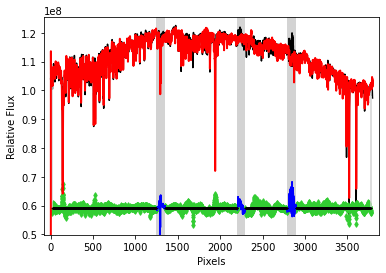

In [7]:
ppxf_fit.plot()

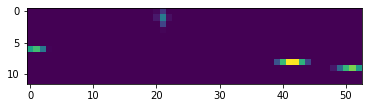

In [8]:
f_ppxf = np.reshape(ppxf_fit.weights, ssps.par_dims)
im_ppxf = f_ppxf
plt.imshow(np.flipud(im_ppxf))
plt.show()

# Truncate young ages

In [9]:
ssps2 = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=None,
    lmd_max=None,
    age_lim=(0.1,14)
    )
ssps2.resample_spectra(m54_data.lmd)
# normalise the SSP templates to be light-weighted rather than mass-weighted,
ssps2.Xw /= np.sum(ssps2.Xw, 0)
ssps2.dv = m54_data.dv
ssps2.speed_of_light = m54_data.speed_of_light

In [10]:
ssps2.X.shape

(53689, 552)

In [11]:
templates = ssps2.Xw
# final pixel is NAN, breaks PPXF even though this is masked, so remove it here manually
templates = templates[:-1,:]

ppxf_fit2 = ppxf.ppxf(
    templates,
    galaxy,
    noise,
    velscale,
    start=start,
    degree=-1,
    mdegree=21,
    moments=moments,
    bounds=bounds,
    regul=1e-10,
    mask=mask
)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.014     0.169
chi2/DOF: 0.9752; degree = -1; mdegree = 21
method = capfit; Jac calls: 10; Func calls: 267; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  18 / 552


/var/folders/s5/ts6_t97x4lbb7lz292_yv_dw0007l9/T/ipykernel_74822/3037749488.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(im_ppxf))


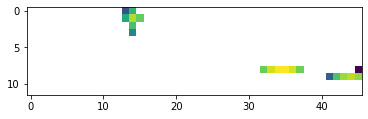

In [12]:
f_ppxf = np.reshape(ppxf_fit2.weights, ssps2.par_dims)
im_ppxf = np.flipud(f_ppxf)
plt.imshow(np.log10(im_ppxf))
plt.show()

In [13]:
ssps.par_dims

(12, 53)

In [14]:
ssps2.par_dims

(12, 46)

Truncating the 7 youngest SSP bins *solves* the problem :P